In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
#constants
pi = np.pi;
e = np.e;

### FFT

In [30]:
def fft(P):

    if(len(P) == 1):
        return P;
    

    P_e = P[0:: 2];
    P_o = P[1:: 2];

    y_e = fft(P_e);
    y_o = fft(P_o);

    y = np.zeros(len(P), dtype=np.complex_);
    w = e**(1j * 2*pi/len(P));
    w0 = 1;

    for i in range(len(y_e)):
        y[i] = w0 * y_o[i] + y_e[i];
        y[i+len(y_e)] = -w0 * y_o[i] + y_e[i];
        w0 *= w;
    

    return y;

def ifft(P, depth = 0):

    if(len(P) == 1):
        return P;
    

    P_e = P[0:: 2];
    P_o = P[1:: 2];

    y_e = ifft(P_e, 1);
    y_o = ifft(P_o, 1);

    y = np.zeros(len(P), dtype=np.complex_);
    w = e**(-1j * 2*pi/len(P));
    w0 = 1;

    for i in range(len(y_e)):
        y[i] = w0 * y_o[i] + y_e[i];
        y[i+len(y_e)] = -w0 * y_o[i] + y_e[i];
        w0 *= w;
    
    if(depth):
        return y;

    return y/len(P);

def fpad(P):

    n = int(2**(np.ceil(np.log2(len(P)))));
    if(len(P)-n==0):
        return P;

    padded = [];
    for i in range(0,  len(P)):
        padded.append(P[i]);
    
    for i in range(len(P), n):
        padded.append(0);

    return np.array(padded, dtype = np.complex_);

### Newton Raphson

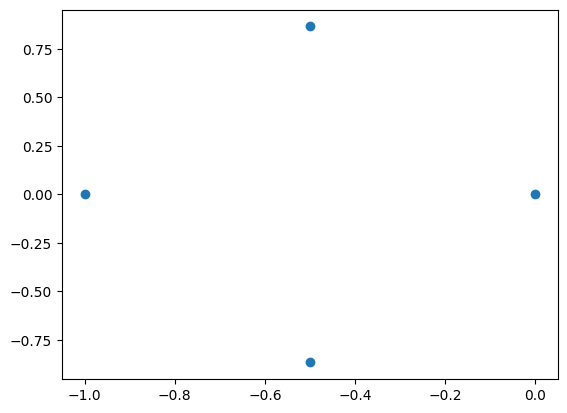

In [233]:
def diff(P):

    dP = [];
    for i in range(1, len(P)):
        dP.append(i*P[i]);
    dP.append(0);
    dP = np.array(dP, dtype=np.complex_);

    return dP;

def remove_trailing_zeros(P):

    n = 0;
    for i in range(len(P)-1, 0, -1):
        if(np.abs(P[i]) > 0.0001):
            n = i;
            break;

    return P[:n+1];

def poly_div(P,Q):
    P = np.array(P, dtype=np.complex_);
    Q = np.concatenate((Q, [0]*(len(P)-len(Q))));

    vP = fft(fpad(P));
    vQ = fft(fpad(Q));

    h = [];
    for i in range(len(vP)):
        if(np.abs(vQ[i])>10**(-3)):
            h.append(vP[i]/vQ[i]);
        else:
            woff = woff = e**(1j * 2*pi*i / len(vP)) + 0.00001 + 1j * 0.00001;
            pows = [woff**i for i in range(len(P))];
            h.append(P.dot(pows)/Q.dot(pows))
    
    return np.array(remove_trailing_zeros(ifft(h)), dtype = np.complex_);


def all_roots(P, niter = 20):

    #create derivative
    P = np.array(P, dtype = np.complex_);
    dP = diff(P);

    #initial guess
    n = len(P);
    roots = [];

    for i in range(n-1):
        x0 = np.random.uniform(-1, 1);
        y0 = np.random.uniform(-1, 1);
        z0 = x0 + 1j * y0;

        for j in range(niter):
            pows = [1];
            zi = 1;
            for k in range(1, len(P)):
                zi *= z0;
                pows.append(zi);

            vp = P.dot(pows);
            vq = dP.dot(pows);

            z0 = z0 - vp/vq;

        P = poly_div(P, [-z0, 1]);
        dP = diff(P);
        roots.append(z0);

    return roots;

q = to_array(piter(p, 2))[::-1]
roots = all_roots(q)
plt.scatter(np.real(roots), np.imag(roots))

In [234]:
#specific newton raphson implementation

def calc(z0, n):
    fz = [z0]
    for i in range(n-1):
        z0 = z0*z0+z0;
        fz.append(z0);
    return np.array(fz);

def spec_newt_raph(z0, n, niter = 20):

    for i in range(niter):
        fz = calc(z0, n);
        prod = 1;
        for z in fz:
            prod *= (2*z+1);
        z0 -= (fz[-1]**2+fz[-1])/prod;
    
    return z0

In [235]:
spec_newt_raph(-1.5 - 1j, 4)

(-1.070695986873045-0.7587449567759897j)

### Composition and roots of f^pq

In [236]:
def piter(p, n):
    q = p;
    for i in range(n-1):
        q = sym.compose(p, q);
    return q

def to_array(p):
    return np.array(sym.Poly(p).all_coeffs(), dtype=np.complex_);

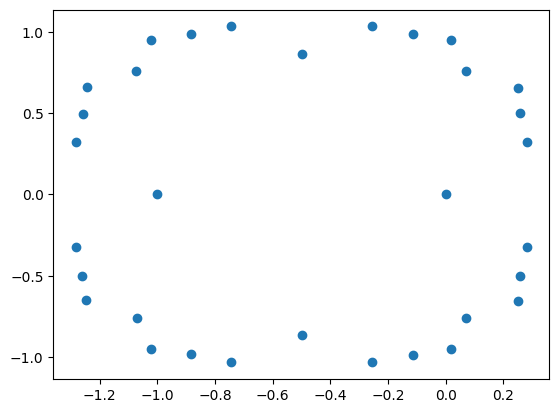

In [240]:
c = sym.Symbol('c')
p = c*c+c

q = to_array(piter(p, 5))[::-1]
roots = all_roots(q, niter=1000)
plt.scatter(np.real(roots), np.imag(roots))

In [147]:
P = [0, 0.5+np.sqrt(3)/2*1j, 1.5+np.sqrt(3)/2*1j, 1]
poly_div(P, [1, 1])

array([-5.91506115e-06-1.58488834e-06j,  5.00005915e-01+8.66026989e-01j,
        9.99994085e-01-1.58488834e-06j])

### Main Event

In [ ]:
def genady_polynomial(c1, p, q):

    genady = [1];

    #start by calculating the inner summands, and keep them in an array
    derv = 1/(2*c1);
    z0 = c1;


    derivs = [derv];

    for i in range(2, p*q+1):
        z0 = z0*z0 + c1;
        if(np.abs(derv)<0.00000000000000001):
            derv = 0;
        
        else:
            derv = derv/(2*z0);
        
        derivs.append(derv);
    
    #now calculate polynomial
    for n in range(1, q):
        genady.append(sum(derivs[p*(n-1)+1 : p*n+1]));
    

    genady.append(sum(derivs[p*(q-1)+1 : p*q]));

    return genady;